In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import time


In [3]:
company='FB' # Facebook ticker
start=dt.datetime(2020,1,1)
end=dt.date.today()


In [4]:
df=pdr.get_data_yahoo(company,start,end)
print(df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  206.750000  209.789993  206.270004  209.779999  209.779999   
2020-01-03  207.210007  210.399994  206.949997  208.669998  208.669998   
2020-01-06  206.699997  212.779999  206.520004  212.600006  212.600006   
2020-01-07  212.820007  214.580002  211.750000  213.059998  213.059998   
2020-01-08  213.000000  216.240005  212.610001  215.220001  215.220001   
...                ...         ...         ...         ...         ...   
2021-06-30  352.170013  352.920013  347.170013  347.709991  347.709991   
2021-07-01  346.820007  354.670013  346.500000  354.390015  354.390015   
2021-07-02  355.100006  356.440002  352.619995  354.700012  354.700012   
2021-07-06  356.500000  358.790009  349.179993  352.779999  352.779999   
2021-07-07  355.260010  356.489990  350.000

In [5]:
#Prepare data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df['Close'].values.reshape(-1,1))
#print(scaled_data)
prediction_days=60
x_train=[]
y_train=[]

for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


In [6]:
#build the model
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
11/11 [==============================] - 8s 57ms/step - loss: 0.1246
Epoch 2/25
11/11 [==============================] - 1s 54ms/step - loss: 0.0303
Epoch 3/25
11/11 [==============================] - 1s 51ms/step - loss: 0.0161
Epoch 4/25
11/11 [==============================] - 1s 50ms/step - loss: 0.0120
Epoch 5/25
11/11 [==============================] - 1s 51ms/step - loss: 0.0093
Epoch 6/25
11/11 [==============================] - 1s 50ms/step - loss: 0.0080
Epoch 7/25
11/11 [==============================] - 1s 51ms/step - loss: 0.0092
Epoch 8/25
11/11 [==============================] - 1s 51ms/step - loss: 0.0083
Epoch 9/25
11/11 [==============================] - 1s 53ms/step - loss: 0.0079
Epoch 10/25
11/11 [==============================] - 1s 52ms/step - loss: 0.0074
Epoch 11/25
11/11 [==============================] - 1s 58ms/step - loss: 0.0070
Epoch 12/25
11/11 [==============================] - 1s 52ms/step - loss: 0.0077
Epoch 13/25
11/11 [==================

In [8]:
#load testing data
test_start=start
test_end=end
test_df=pdr.get_data_yahoo(company,test_start,test_end)
real_prices= test_df['Close'].values
total_dataset= pd.concat((df['Close'],test_df['Close']),axis=0)
model_inputs =total_dataset[len(total_dataset)-len(test_df)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scaler.transform(model_inputs)

x_test =[]

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
    
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
prediction_prices=model.predict(x_test)
prediction_prices=scaler.inverse_transform(prediction_prices)


[*********************100%***********************]  1 of 1 completed


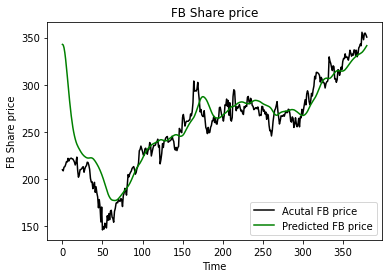

In [9]:
#Plot test predicitions
plt.plot(real_prices,color='black',label=f"Acutal {company} price")
plt.plot(prediction_prices,color='green',label=f"Predicted {company} price")
plt.title(f"{company} Share price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share price")
plt.legend()
plt.show()


In [10]:
real_data=[model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data=np.array(real_data)
real_data=np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
prediction =model.predict(real_data)
prediction=scaler.inverse_transform(prediction)
print(f"Prediction: {prediction[0][0]}")

Prediction: 342.7389221191406
